[*********************100%***********************]  1 of 1 completed


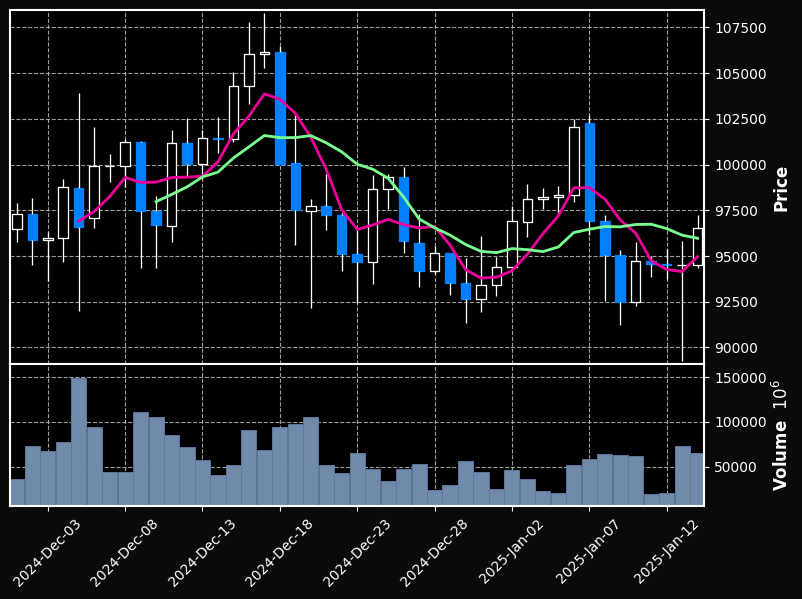

In [ ]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd

df = yf.download('BTC-USD', start='2024-12-01')

df.columns = [col[0] for col in df.columns]

df = df.dropna()  

df.index = pd.to_datetime(df.index)

mpf.plot(
    df,
    type='candle',
    volume=True,
    mav=(5, 10), 
    tight_layout=True, 
    style='mike', 
    show_nontrading=True
)


In [ ]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

def fetch_data_from_yfinance(ticker, period):
    data = yf.download(ticker, period=period, interval='1d')
    if data.empty:
        raise ValueError("Nie udało się pobrać danych z yfinance.")
    
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

ticker = "BTC-USD"
period = "3mo"
data = fetch_data_from_yfinance(ticker, period)

data = data.dropna()
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data = data.dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values)

time_step = 7
X, y = [], []
for i in range(len(scaled_data) - time_step - 1):
    X.append(scaled_data[i:(i + time_step), 0])
    y.append(scaled_data[i + time_step, 0])
X, y = np.array(X).reshape(-1, time_step, 1), np.array(y)

train_size = int(len(X) * 0.7)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(time_step, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[early_stopping], verbose=1)

test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

future_days = 3  
last_sequence = scaled_data[-time_step:]  
future_predictions = []

for _ in range(future_days):
    next_prediction = model.predict(last_sequence.reshape(1, time_step, 1), verbose=0)
    future_predictions.append(next_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_prediction

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=future_days, freq='D')
future_df = pd.DataFrame({'Predicted': future_predictions.flatten()}, index=future_dates)

data['Predicted'] = np.nan
data = pd.concat([data, future_df])

mpf_data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
mpf_data.index = pd.to_datetime(data.index)

add_plot = [
    mpf.make_addplot(data['Predicted'], color='red', width=2, secondary_y=False)
]

mpf.plot(
    mpf_data,
    type='candle',
    volume=True,
    addplot=add_plot,
    style='mike',
    title='BTC-USD Price with Future Predictions',
    ylabel='Price (USD)',
    ylabel_lower='Volume',
    mav=(5, 10),
    tight_layout=True,
    show_nontrading=True
)


In [ ]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

def fetch_data_from_yfinance(ticker, period):
    data = yf.download(ticker, period=period, interval='1d')
    if data.empty:
        raise ValueError("Nie udało się pobrać danych z yfinance.")
    
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

ticker = "BTC-USD"
period = "3mo"
data = fetch_data_from_yfinance(ticker, period)

data = data.dropna()
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data = data.dropna()

scalers = {}
scaled_data = {}
for col in ['Open', 'High', 'Low', 'Close']:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scalers[col] = scaler
    scaled_data[col] = scaler.fit_transform(data[[col]])

time_step = 7
X, y = [], []
for i in range(len(data) - time_step - 1):
    input_data = np.column_stack([scaled_data[col][i:(i + time_step), 0] for col in ['Open', 'High', 'Low', 'Close']])
    X.append(input_data)
    y.append([scaled_data[col][i + time_step, 0] for col in ['Open', 'High', 'Low', 'Close']])

X, y = np.array(X), np.array(y)

train_size = int(len(X) * 0.7)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(time_step, 4)),  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4)  
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[early_stopping], verbose=1)

test_predict = model.predict(X_test)
test_predict = {col: scalers[col].inverse_transform(test_predict[:, i:i + 1]) for i, col in enumerate(['Open', 'High', 'Low', 'Close'])}

future_days = 7
last_sequence = X_test[-1]  
future_predictions = []

for _ in range(future_days):
    next_prediction = model.predict(last_sequence.reshape(1, time_step, 4), verbose=0)
    future_predictions.append(next_prediction[0])
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1] = next_prediction[0]

future_predictions = pd.DataFrame({
    col: scalers[col].inverse_transform(np.array(future_predictions)[:, i].reshape(-1, 1)).flatten()
    for i, col in enumerate(['Open', 'High', 'Low', 'Close'])
})

future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=future_days, freq='D')
future_predictions['Volume'] = 0  
future_predictions.index = future_dates

data = pd.concat([data, future_predictions])

mpf_data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
mpf_data.index = pd.to_datetime(data.index)

mpf.plot(
    mpf_data,
    type='candle',
    volume=True,
    style='mike',
    title='BTC-USD Price with Future Candlesticks Predictions',
    ylabel='Price (USD)',
    ylabel_lower='Volume',
    mav=(5, 10),
    tight_layout=True,
    show_nontrading=True
)


In [ ]:
import sys
import time
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def fetch_data_from_yfinance(ticker, period):
    data = yf.download(ticker, period=period, interval='1d')
    if data.empty:
        raise ValueError("Nie udało się pobrać danych z yfinance.")
    data = data[['Close']].rename(columns={'Close': 'price'})
    return data

ticker = "BTC-USD"
period = "5y"
data = fetch_data_from_yfinance(ticker, period)

if data.empty or 'price' not in data.columns:
    raise ValueError("Nie udało się pobrać danych lub kolumna 'price' jest niedostępna.")
data['price'].fillna(method='ffill', inplace=True)

print("\nPodstawowe statystyki:")
print(data.describe())

print("\nInformacje o danych:")
data.info()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['price'], label='Price', color='blue')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Historical date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

data['month'] = data.index.month
monthly_avg = data.groupby('month')['price'].mean()
plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Average Monthly Bitcoin Price')
plt.xlabel('Month')
plt.ylabel('Average Price (USD)')
plt.grid(axis='y')
plt.show()

data['price'].plot(kind='hist', bins=50, figsize=(10, 5), title='Price Distribution', color='blue')
plt.xlabel('Price')
plt.grid()
plt.show()

decomposition = seasonal_decompose(data['price'], model='additive', period=30)

plt.figure(figsize=(14, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.title('Observed')
plt.grid()


plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Trend')
plt.grid()


plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.title('Seasonal')
plt.grid()


plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.title('Residual')
plt.grid()
plt.tight_layout()
plt.show()

train_size = int(len(data) * 0.7)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data['price'].values.reshape(-1, 1))
test_scaled = scaler.transform(test_data['price'].values.reshape(-1, 1))

def build_dataset(dataset, time_step=7):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])  
        y.append(dataset[i + time_step, 0])  
    return np.array(X).reshape(-1, time_step, 1), np.array(y)

time_step = 7
X_train, y_train = build_dataset(train_scaled, time_step)
X_test, y_test = build_dataset(test_scaled, time_step)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(time_step, 1)),  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

start_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)
training_time = time.time() - start_time

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.grid()
plt.show()

start_time = time.time()
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
inference_time = time.time() - start_time
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['price'], label='Actual Data', color='blue')
plt.plot(data.index[-len(test_predict):], test_predict.flatten(), label='Test Predictions', color='orange', linestyle='dashed')
plt.title('Historical Data and Test Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

print('\n Metryki czasowe:')
print(f'Czas treningu: {training_time:.2f} sekund')
print(f'Czas inferencji: {inference_time:.2f} sekund')

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mae_train = mean_absolute_error(y_train_actual, train_predict)
mae_test = mean_absolute_error(y_test_actual, test_predict)

mse_train = mean_squared_error(y_train_actual, train_predict)
mse_test = mean_squared_error(y_test_actual, test_predict)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train_actual, train_predict)
r2_test = r2_score(y_test_actual, test_predict)

print("Metryki skuteczności modelu RNN-BiLSTM:")
print(f"MAE (Train): {mae_train:.4f}, MAE (Test): {mae_test:.4f}")
print(f"MSE (Train): {mse_train:.4f}, MSE (Test): {mse_test:.4f}")
print(f"RMSE (Train): {rmse_train:.4f}, RMSE (Test): {rmse_test:.4f}")
print(f"R² (Train): {r2_train:.4f}, R² (Test): {r2_test:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(data.index[:len(train_predict)], train_predict, label='Train Predictions', color='green', linestyle='dashed')
plt.plot(data.index[-len(test_predict):], test_predict, label='Test Predictions', color='orange', linestyle='dashed')
plt.plot(data.index, data['price'], label='Historical Data', color='blue')
plt.title('Model Performance')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


num_prediction_days = 7
last_sequence = X_test[-1]
future_predictions = []

for _ in range(num_prediction_days):
    last_sequence_new = last_sequence.reshape((1, time_step, 1))
    next_prediction = model.predict(last_sequence_new, verbose=0)
    future_predictions.append(next_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_prediction

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=num_prediction_days, freq='D')

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['price'], label='Actual Data', color='blue')
plt.axvline(x=data.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(future_dates, future_predictions.flatten(), label='Future Predictions', color='red', linestyle='dotted')
plt.title('Historical Data and Future Predictions (RNN-LSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
